**ML COURSE 2024-2025**
# LAB2: Linear / Ridge Regression and Cross-Validation

#### Summary
- **Linear Regression**
    - MSE and $R^2$ score
    - Feature augmentation
- **Ridge Regression**
    - Normalization and Unnormalization
- **Cross-Validation**
    - K-Fold Cross-Validation
    - Monte-Carlo Cross-Validation

## Linear Regression

In this notebook, we will implement linear regression from scratch using numpy.

> Linear regression: find the best line that fits the data.

**But how do we quantify what "best" means?**

We need a way to mathematically "judge" how well our linear model fits the data.

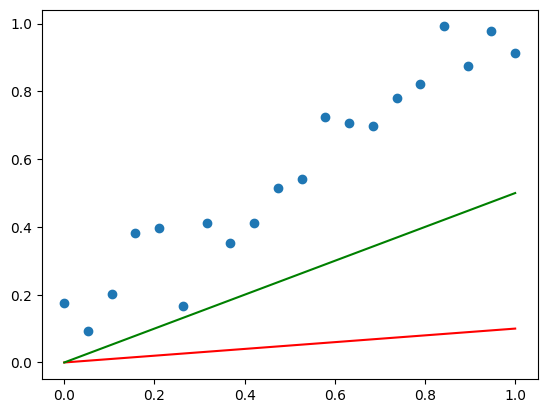

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Make the random generation fixed
np.random.seed(0)

# Generate data with a noisy linear function
x = np.linspace(0, 1, 20)
y = x + np.random.normal(0, 0.1, 20)

line1 = 0.1 * x
line2 = 0.5 * x

plt.scatter(x, y)
plt.plot(x, line1, "r")
plt.plot(x, line2, "g")

Is the red line better than the green line? We need a mathematical way to answer this question.

> To evaluate how well our linear model fits the data, we will use the *mean squared error (MSE)* loss function.

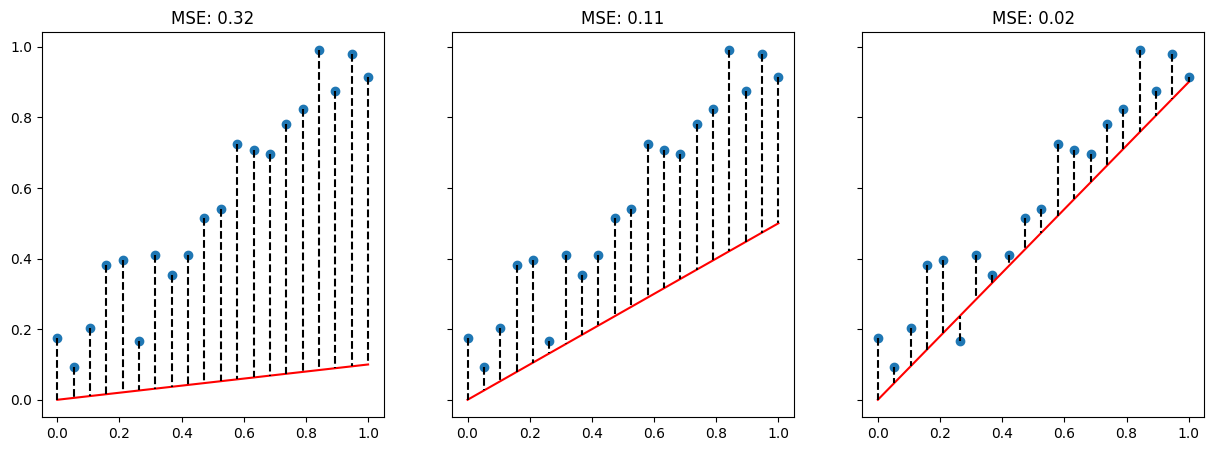

In [24]:
from utils import plot_mse

# Check the MSE of different lines
line_1 = 0.1 * x
line_2 = 0.5 * x
line_3 = 0.9 * x

plot_mse(x, y, line_1, line_2, line_3)

The slope is one of the parameters of a linear model, and we can add an offset too:

$$\hat{y} = mx + b$$

Where:
- $\hat{y}$ is the target variable (with $\hat{\;}$ because it's the model's prediction)
- $x$ is the input variable
- $m$ is the slope
- $b$ is the offset

As you can see, as we change the parameters of our model, the error changes.

The formula we used to evaluate how well the model fits the data is the following:

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

where:
- $n$ is the number of data points
- $y_i$ is the actual value of the data point
- $\hat{y}_i$ is the predicted value of the data point

In [25]:
# Numpy can be used to define the mean squared error
# - y is the true value
# - y_pred is the predicted value
def mse(y, y_pred):
    return np.mean((y - y_pred) ** 2)

That formula tells us how well our model fits the data, but how do we find the best parameters?

We need an algorithm to find the best parameters (slope and offset) that minimize the loss function.

‚≠ê Luckily, linear regression with MSE loss function can be solved analytically with the Ordinary Least Squares (OLS) method.

### Ordinary Least Squares (OLS)

The OLS method finds the best parameters by minimizing the mean squared error loss function.

To find the slope that best fits the data, we divide the covariance of $x$ and $y$ by the variance of $x$:

$$
m = \frac{cov(x, y)}{var(x)}
$$

And to find the offset, we use the following formula:

$$
b = \bar{y} - m \bar{x}
$$

Where:
- $\bar{x}$ is the mean of $x$
- $\bar{y}$ is the mean of $y$

This is the scalar form of the formula, meaning it works for a single input variable and a single target variable.

**But what if we have multiple input variables?**

We have to solve a system of linear equations, which can be done in a compact form using matrices. The closed-form solution for OLS in matrix form, for $\beta = [\beta_0, \beta_1, ..., \beta_p]^T$ is:
$$
\mathbf{\beta}= (\mathbf{X^T} \mathbf{X})^{-1}\mathbf{X^T} \mathbf{y}
$$
where:
- $y$ is the target variable
- we have expanded the input matrix $\mathbf{X}$ with a column of 1s to compute also the bias term $\beta_0$:
$$
\mathbf{X} =
\begin{bmatrix}
    1 & x_{11} & x_{12} & \dots & x_{1p} \\
    1 & x_{21} & x_{22} & \dots & x_{2p} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_{n1} & x_{n2} & \dots & x_{np}
\end{bmatrix}
$$

Once we have the $\beta$ vector, we can use it to predict $\hat{y}$ given the input vector $X$:

$$
\hat{y} = X \beta
$$

In [26]:
import seaborn as sns
import pandas as pd

# Create some multiple linear regression data
np.random.seed(0)
n = 300
# multiply by 50 to make the features range from 0 to 50, as an example
x1 = np.random.rand(n) * 50
x2 = np.random.rand(n) * 50

# This is the true function we want to estimate
m1 = 1.5
m2 = -1
b = 50
y = m1 * x1 + m2 * x2 + b

# We can write this in matrix form, by creating directly a matrix X
X_matrix = np.random.rand(n, 2) * 50

# And stacking the coefficients in a vector M
M = np.array([m1, m2])

# We can then write the linear regression as a matrix multiplication
y = X_matrix @ M + b

# Add some noise to the data, because real data is usually noisy
y = y + np.random.normal(0, 0.1, n)

**Example**

In this case we have 2 input variables:
- $x1$ is the number of hours studied
- $x2$ is the number of hours spent on social media (doomscrolling)

We would like to predict the final grade (out of 100) which we call $y$, given those 2 input variables.

In [27]:
# Create a DataFrame just to plot the data
df = pd.DataFrame({"x1 Study Hours": X_matrix[:, 0], "x2 Doomscrolling Hours": X_matrix[:, 1], "y Exam Grade": y})
df

x1 Study Hours  x2 Doomscrolling Hours  y Exam Grade
0          8.732919               16.399400     46.735261
1         34.017433                3.160381     97.850492
2         30.362469               23.882325     71.531509
3         14.199999               11.920664     59.506942
4         25.725637               18.396379     70.324578
..              ...                     ...           ...
295       40.807538               45.572544     65.726814
296       13.816858               18.476177     52.203701
297       18.994695               28.022529     50.478109
298       33.410911               14.335834     85.855728
299        0.973123               19.961119     31.554865

[300 rows x 3 columns]

<Axes: xlabel='x2 Doomscrolling Hours', ylabel='y Exam Grade'>

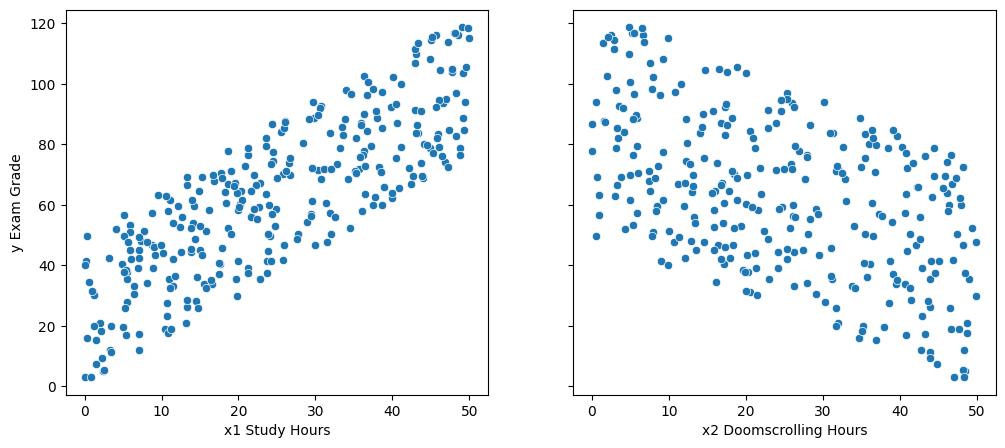

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.scatterplot(data=df, x="x1 Study Hours", y="y Exam Grade", ax=axs[0])
sns.scatterplot(data=df, x="x2 Doomscrolling Hours", y="y Exam Grade", ax=axs[1])

In [29]:
# Step 1: Add a column of ones to X to account for the intercept term
X = np.hstack((X_matrix, np.ones((X_matrix.shape[0], 1))))
print(f"first 10 elements of X:\n{X[:10]}")

first 10 elements of X:
[[ 8.73291927 16.39940005  1.        ]
 [34.0174333   3.16038092  1.        ]
 [30.3624687  23.88232514  1.        ]
 [14.19999884 11.92066405  1.        ]
 [25.72563716 18.39637903  1.        ]
 [22.82599456 16.87386909  1.        ]
 [48.52468468  6.67197159  1.        ]
 [ 4.84019766 17.16958644  1.        ]
 [29.55134504 32.95882359  1.        ]
 [19.86283736 49.9638997   1.        ]]


In [30]:
# Step 2: Calculate the OLS parameters
# Remembder this equation? Œ≤ = (X^T X)^-1 X^T y

# X.T is the transpose of X
# np.linalg.inv() computes the inverse of a matrix
# @ is the matrix multiplication operator
beta = np.linalg.inv(X.T @ X) @ X.T @ y
print(f"beta: {beta}")

beta: [ 1.50012436 -0.99988907 50.00796814]


Define a function so that we can use this estimator in the future.

In [31]:
def compute_beta_lin_reg(X, y):
  X = np.hstack((np.ones((X.shape[0], 1)), X))
  return np.linalg.inv(X.T @ X) @ X.T @ y

In [32]:
# Extract the coefficients from beta
# in vector form
M_model = beta[1:]
b_model = beta[0]

# Print the coefficients
print(f"M_model = {M_model}")
print(f"b_model = {b_model}")

print("\nWhile the true coefficients are:")
print(f"M = {M}")
print(f"b = {b}")

M_model = [-0.99988907 50.00796814]
b_model = 1.500124358958262

While the true coefficients are:
M = [ 1.5 -1. ]
b = 50


In this fictional example, we have found out that:

The linear relation between the input variables and the target variable as follows:

> For each 1.5 hours studied, the final grade increases by 1 point, and for each hour spent on social media, the final grade decreases by 1 points.

The bias, or offset, is 50 because if you don't study at all and spend no time on social media, you will get 50 points (basically the average grade).

In [33]:
# Compute predictions
y_pred =

# Compute the MSE
print(f"MSE: {mse(y, y_pred):.4f}")

SyntaxError: invalid syntax (<ipython-input-33-75383071c6e4>, line 2)

## $R^2$ Score

The $R^2$ score is a metric that tells us how well our model fits the data, but it's more interpretable than the mean squared error.

This score is a value between 0 and 1, where 1 means the model perfectly explains the linear relationship between the input and target variables.

The formula for the $R^2$ score is the following:

$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$

Where:

$$
SS_{res} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

$$
SS_{tot} = \sum_{i=1}^{n} (y_i - \bar{y})^2
$$

In [ ]:
# Given y and y_pred, we can compute the residuals

# Residual Sum of Squares (RSS)


In [ ]:
# Total Sum of Squares (TSS)
# This is the sum of the squared differences between the true value and the mean of the true values


In [ ]:
# Now we can compute the R^2


Let's implement a function that calculates the $R^2$ score in a compact and reusable way.

This is very important for code clarity and to avoid potential bugs.

In [ ]:
# We can put all the operations we just did in a single function
def r_squared(y, y_pred):
    ...

Let's try with a bad model to see how the $R^2$ score changes.

In [ ]:
beta_bad = np.array([0, -1, 1])

# Compute predictions
y_pred_bad = ...

# Compute the MSE
print(f"MSE: {mse(y, y_pred_bad):.4f}")

# Compute the R^2
print(f"R^2: {r_squared(y, y_pred_bad):.4f}")

Here the $R^2$ score is even negative, which means the model is worse than predicting the mean of the target variable.

**Disclaimer:**

I know that 3d plots are usually not the best way to visualize data, but in this case, it's a good way to see how the model fits the data.

Let's see the 3d plot of the good model and the bad model.

- The plane represents the linear model
- The points represent the data

In [ ]:
from utils import plot_multiple_lin_reg


plot_multiple_lin_reg(df, "y Exam Grade", beta)

In [ ]:
plot_multiple_lin_reg(df, "y Exam Grade", beta_bad)

## Feature Augmentation

Feature augmentation is a technique used to improve the expressiveness of linear models.

In this case, we will add polynomial features to the input variables to better fit the data.

In [ ]:
# Let's create data with only one feature
np.random.seed(0)
n = 20
x = np.random.rand(n)
y = 3 * x ** 2 -2 * x + 1 + np.random.normal(0, 0.1, n)

# Create a DataFrame just to plot the data
df = pd.DataFrame({"x": x, "y": y})
df

In [ ]:
sns.scatterplot(data=df, x="x", y="y")

Now let's try fitting a linear model to the data, this is the best we can do with a linear model.

In [ ]:
beta = compute_beta_lin_reg(x.reshape(-1, 1), y)

model = beta[1] * x + beta[0]

sns.scatterplot(data=df, x="x", y="y")
plt.plot(x, model, "r")

print(f"MSE: {mse(y, model):.4f}")
print(f"R^2: {r_squared(y, model):.4f}")

To fix this, we can add **polynomial features** to the input variables.

In [ ]:
# First, create an array which is the square of the input variable.
x_2 = x ** 2

# And then stack the two arrays together, to create the X matrix, where each row is [x^2, x]
X = np.vstack((x_2, x)).T

In [ ]:
# Then we can use our usual function to compute the linear regression coefficients
beta = compute_beta_lin_reg(X, y)

In [ ]:
# And compute the predictions as the X matrix multiplied by the coefficients plus the intercept
y_pred = X @ beta[1:] + beta[0]

sns.scatterplot(data=df, x="x", y="y", label="True values")

# We can plot the model as well, so we may want to compute the x values as a range from the minimum to the maximum
x_min, x_max = np.min(x), np.max(x)
x_grid = np.linspace(x_min, x_max, 100)

# Compute the y values using the model
y_model = beta[0] + beta[1] * x_grid ** 2 + beta[2] * x_grid

# And plot the model
plt.plot(x_grid, y_model, "r", label="Model")
plt.legend()

This works very well if we know the data may have a polynomial relationship. But in general we may not know the relationship between the input and target variables, especially when working with high dimensional data.

So in general, we can add as many polynomial features as we want, let's try.

In [ ]:
# Define a function that augments a feature with polynomial terms
def augment_feature(x, degree):
    X = np.vstack([x ** i for i in range(1, degree + 1)]).T
    return X

We may have overfit the data, the model is too complex and doesn't generalize well.

In [ ]:
degree = 9
X_poly = augment_feature(x, degree)

beta = compute_beta_lin_reg(X_poly, y)

X_grid = np.linspace(np.min(x), np.max(x), 1000)
X_grid = augment_feature(X_grid, degree)

y_pred = X_grid @ beta[1:] + beta[0]

sns.scatterplot(data=df, x="x", y="y", label="Input data")
plt.plot(X_grid[:, 0], y_pred, c="r", label="Model")
plt.legend()

## Ridge Regression

Ridge Regression estimates coefficients by minimizing
$$
RSS + \lambda \sum_{j=\textcolor{red}{1}}^{p} \beta _j^2
$$

#### Do not penalize the bias term üö´   
Note that the regularization parameter $\lambda$ is applied only to $\beta_1, ..., \beta_p$, not to the intercept/bias term $\beta_0$. Why?
- We want to shrink the feature weights with respect to the response, to reduce model complexity and prevent overfitting.
- But the intercept is not a feature weight, it simply measures the mean response when $x_{i1} = x_{i2} =...=x_{ip}=0.$
- If we penalize $\beta_0$, the model would be forced toward zero-centered predictions (i.e. small $\beta_0$) which might be wrong.

#### Closed-form solution in matrix form
$$
\mathbf{\beta}= (\mathbf{\tilde{X}^T} \mathbf{\tilde{X}}+\lambda \mathbf{\tilde{I}})^{-1}\mathbf{\tilde{X}^T} \mathbf{y}
$$
where:
- $\tilde{X}$ is the expanded matrix, with all the features standardized (to have zero-mean and unit variance) and where we added the column of 1s:
$$
\tilde{x}_{ij} = \frac{x_{ij}-\mu_j}{\sigma_j}\quad
\rightarrow \quad
\mathbf{\tilde{X}} =
\begin{bmatrix}
    1 & \tilde{x}_{11} & \tilde{x}_{12} & \dots & \tilde{x}_{1p} \\
    1 & \tilde{x}_{21} & \tilde{x}_{22} & \dots & \tilde{x}_{2p} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & \tilde{x}_{n1} & \tilde{x}_{n2} & \dots & \tilde{x}_{np}
\end{bmatrix}
$$
- $\lambda$ is the regularization parameter controlling the penalty on the coefficients magnitude.
- $\mathbf{\tilde{I}}$ is a identity-like matrix with a zero in first entry (because the column of 1s is the first one):
$$
\mathbf{\tilde{I}} =
\begin{bmatrix}
    \textcolor{red}{0} & 0 & \dots & 0 & 0 \\
    0 & 1 & \dots & 0 & 0 \\
    \vdots & \vdots & \ddots & \vdots & \vdots \\
    0 & 0 & \dots & 1 & 0 \\
    0 & 0 & \dots & 0 & 1 \\
\end{bmatrix}
$$
This structure ensures that $\lambda$ only penalizes $\beta_1,...\beta_p$ and not $\beta_0$. You can write the solution in expanded form to verify this.

<div style="background-color: lightblue; padding: 10px; color: black">
    <strong> ‚ö†Ô∏è Warning! Standardization in Ridge Regression is necessary. </strong>
    Ridge Regression shrinks the magnitude of the coefficients to prevent overfitting. However, if features have different scales, Ridge will penalize large-scale features less, making regularization ineffective (look at 'Introduction to statistical learning'!)
</div>


In [ ]:
# 1. Standardize the features
X_mean = np.mean(X_poly, axis=0)
X_std = np.std(X_poly, axis=0)
X_norm = (X_poly - X_mean) / X_std


In [ ]:
# 2. Define and train the model
def compute_beta_ridge(X, y, lambda_):
    # expand the input matrix to include the bias term
    ...
    # define the identity-like matrix
    ...

    # compute the coefficients
    ...
    return beta

lambda_ = 0.1
beta_ridge = compute_beta_ridge(X_norm, y, lambda_)
print(beta_ridge.shape)

In [ ]:
# Compute also the beta_OLS on the normalized data, and let's compare the coefficients
beta_ols = compute_beta_lin_reg(X_norm, y)

# Let's print the coefficients
print("{:<10} {:<20} {:<20}".format("Coeff", "Œ≤_Ridge", "Œ≤_OLS"))
print("-" * 50)
for i in range(len(beta_ridge)):
    index_label = f"Œ≤{i}"
    print("{:<10} {:<20.6f} {:<20.6f}".format(index_label, beta_ridge[i], beta_ols[i]))

In [ ]:
# 3. Compute predictions
y_pred_ridge = beta_ridge[0] + X_norm @ beta_ridge[1:]
y_pred_ols = beta_ols[0] + X_norm @ beta_ols[1:]

In [ ]:
# 4. Evaluate the model
mse_ridge = mse(y, y_pred_ridge)
mse_ols = mse(y, y_pred_ols)
r2_ridge = r_squared(y, y_pred_ridge)
r2_ols = r_squared(y, y_pred_ols)

print("MSE-Ridge: ", mse_ridge)
print("MSE-OLS: ", mse_ols)
print("R^2-Ridge: ", r2_ridge)
print("R^2-OLS: ", r2_ols)


<strong> ‚ùå This is the wrong way to evaluate a model! </strong> Oh no! Ridge appears to perform worse than OLS üò¢. This happens because we did not split the dataset into training and testing sets. Therefore, we are not evaluating the model's generalization ability but only how well it fits (or overfit!) the training data.

In [ ]:
# let's create a test set (not seen in training)
n_test = 20
x_test = np.random.rand(n_test)
y_test = 3 * x_test ** 2 - 2 * x_test + 1 + np.random.normal(0, 0.1, n_test)

# augment the test set
X_test = augment_feature(x_test, degree)

# standardize the test set
X_test_norm = (X_test - X_mean) / X_std

# compute the predictions
y_pred_test_ridge = beta_ridge[0] + X_test_norm @ beta_ridge[1:]
y_pred_test_ols = beta_ols[0] + X_test_norm @ beta_ols[1:]

# compute the MSE
mse_test_ridge = mse(y_test, y_pred_test_ridge)
mse_test_ols = mse(y_test, y_pred_test_ols)
r2_test_ridge = r_squared(y_test, y_pred_test_ridge)
r2_test_ols = r_squared(y_test, y_pred_test_ols)

# Ridge actually works üòÑ
print("MSE-Ridge (test): ", mse_test_ridge)
print("MSE-OLS (test): ", mse_test_ols)
print("R^2-Ridge (test): ", r2_test_ridge)
print("R^2-OLS (test): ", r2_test_ols)

In [ ]:
# Visualize the model
X_grid = np.linspace(np.min(x), np.max(x), 1000)
X_grid = augment_feature(X_grid, degree)
X_grid_norm = (X_grid - X_mean) / X_std

y_pred_ridge = beta_ridge[0] + X_grid_norm @ beta_ridge[1:]
y_pred_ols = beta_ols[0] + X_grid_norm @ beta_ols[1:]

sns.scatterplot(data=df, x="x", y="y", label="Training data")
plt.plot(X_grid[:, 0], y_pred_ols, c="r", label="OLS")
plt.plot(X_grid[:, 0], y_pred_ridge, c="g", label="Ridge")
plt.legend()
plt.show()

### How to go back to coefficients of unnormalized data (for interpretability)
If we standardize data, we are finding the coefficients of the model:
$$
\hat{Y} = \beta_0 + \sum_{j=1}^{p} \beta_j \frac{X_j-\mu_j}{\sigma_j}
$$

What if we want to go back, i.e. we want find the coefficients for unnormalize data? We can decompose the formula above as:
$$
\hat{Y} = \left( \beta_0 - \sum_{j=1}^{p} \beta_j \frac{\mu_j}{\sigma_j} \right) + \sum_{j=1}^{p} \beta_j \frac{X_j}{\sigma_j}
$$
so, the intercept will become
$$
\beta_0^{un} = \beta_0 - \sum_{j=1}^{p} \beta_j \frac{\mu_j}{\sigma_j}
$$
and the weights:
$$
\beta_j^{un} = \frac{\beta_j}{\sigma_j}
$$

In [ ]:
# let's try to compute the unnormalized version of the coefficients
beta0_ols_unnorm = beta_ols[0] - np.sum(beta_ols[1:] * X_mean / X_std)
beta_ols_unnorm = beta_ols[1:] / X_std

print("Unnormalized OLS coefficients: ", beta0_ols_unnorm, beta_ols_unnorm)
print("Coefficient on unnormalized data: ", beta)
print("They are the same!")

### Coefficients magnitude as function of Œª

In [ ]:
lambdas_ = np.logspace(-2, 3, 100)                          # let's plot the coefficients for a range of lambdas from 0.01 to 1000 with 100 points
coefficients = np.zeros((len(lambdas_), X_poly.shape[1]))

for i, lambda_ in enumerate(lambdas_):
    beta_ridge = compute_beta_ridge(X_norm, y, lambda_)
    coefficients[i, :] = beta_ridge[1:]                     # let's exclude the bias term (which is NOT regularized)

plt.figure(figsize=(10, 6))
for i in range(X_poly.shape[1]):
    plt.plot(lambdas_, coefficients[:, i], label=f"Œ≤{i+1}")
plt.xlabel("Œª")
plt.xscale("log")
plt.ylabel("Coefficient value")
plt.legend()
plt.show()


## Cross validation in a real dataset

| **Procedure w/out Cross-Validation** | **Procedure with k-Fold Cross-Validation** | **Procedure with Monte Carlo Cross-Validation** |
|--------------------------------------|--------------------------------------------|-----------------------------------------------|
| 1. Load data <br> 2. Train-test split <br> 3. (Standardize train and test features using training statistics) <br> 4. Expand the input matrix to account for bias <br> 5. Train the model: find Œ≤ <br> 6. Make predictions <br> 7. Evaluate model on test set | 1. Load data <br> 2. Split data into k folds <br> 3. For each fold: <br> &nbsp;&nbsp;&nbsp; a. Use k-1 folds for training and 1-fold for test <br> &nbsp;&nbsp;&nbsp; b. (Standardize train and test features using training statistics) <br> &nbsp;&nbsp;&nbsp; c. Train the model: find Œ≤ <br> &nbsp;&nbsp;&nbsp; d. Make predictions <br> &nbsp;&nbsp;&nbsp; e. Evaluate performance on test set <br> 4. Aggregate results across folds | 1. Load data <br> 2. Repeat for N iterations: <br> &nbsp;&nbsp;&nbsp; a. Randomly split the data into training and test set <br> &nbsp;&nbsp;&nbsp; b. (Standardize train and test features using training statistics) <br> &nbsp;&nbsp;&nbsp; c. Train the model: find Œ≤ <br> &nbsp;&nbsp;&nbsp; d. Make predictions <br> &nbsp;&nbsp;&nbsp; e. Evaluate performance on test set <br> 3. Aggregate results across iterations |


### K-fold cross validation

In [ ]:
# 1. Load data
np.random.seed(0)

from sklearn.datasets import fetch_california_housing
cali_house = fetch_california_housing()
X = cali_house['data']
y = cali_house['target']
feature_names = cali_house['feature_names']
print("Feature names:", feature_names)

# select only features MedInc, HouseAge, AveRooms, AveOccup as done in class
X = X[:, [0, 1, 2, 5]]


# Note: this dataset is already clean, and all features are relevant. There is no benefit to use ridge regression
# in this case. So, let's corrupt it for didactic purposes by adding multicollinearity and irrelevant features.
# comment from here --------------
X_collinear1 = X[:, 0] * 2.5 + X[:, 1] * 0.5  # Collinear with MedInc and HouseAge
X_collinear2 = X[:, 2] * 1.2 + X[:, 3] * 0.8  # Collinear with AveRooms and AveOccup
X_collinear3 = X[:, 0] * 1.1 + X[:, 2] * 0.9  # Collinear with MedInc and AveRooms
X_collinear1 = X_collinear1.reshape(-1, 1)
X_collinear2 = X_collinear2.reshape(-1, 1)
X_collinear3 = X_collinear3.reshape(-1, 1)

X_noise1 = np.random.normal(0, 1, size=(X.shape[0], 10))     # 10 features of white noise
X_noise2 = np.random.uniform(-3, 2, size=(X.shape[0], 10))  # 10 features of uniform noise

# add the new features to the original dataset
X = np.hstack((X, X_collinear1, X_collinear2, X_collinear3, X_noise1, X_noise2))
# ----------------- to here to use the original dataset

n_samples = X.shape[0]
n_features = X.shape[1]
print("Number of samples:", n_samples)
print("Number of features:", n_features)

In [ ]:
# define model functions
def fit_OLS(X, y):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta

def fit_ridge(X, y, lambda_):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    I_tilde = np.eye(X.shape[1])
    I_tilde[0, 0] = 0
    beta = np.linalg.inv(X.T @ X + lambda_ * I_tilde) @ X.T @ y
    return beta

In [ ]:
# 2. Split data into k fold
k = 5                       # number of folds
fold_size = len(X) // k     # size of each fold

# shuffle data: k-fold cross validation randomly splits the data into k folds
np.random.seed(0)
shuffled_indices = np.random.permutation(len(X))
X_shuffled = X[shuffled_indices]
y_shuffled = y[shuffled_indices]

In [ ]:
# 3. For each fold...
mse_folds_ols = []
mse_folds_ridge = []
r2_folds_ols = []
r2_folds_ridge = []

for i in range(k):
    # a. Split data into train and test
    # define test indices
    start = i*fold_size
    end = (i+1)*fold_size
    test_indices = np.arange(start, end)

    # train indices are the remaining indices
    train_indices = train_indices = np.concatenate((np.arange(0, start), np.arange(end, n_samples)))

    X_train = X_shuffled[train_indices]
    y_train = y_shuffled[train_indices]
    X_test = X_shuffled[test_indices]
    y_test = y_shuffled[test_indices]

    # b. Standardize data
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std

    # c. fit models
    beta_ols = fit_OLS(X_train, y_train)
    beta_ridge = fit_ridge(X_train, y_train, lambda_=10)

    # d. predict on test set
    y_pred_ols = X_test @ beta_ols[1:] + beta_ols[0]
    y_pred_ridge = X_test @ beta_ridge[1:] + beta_ridge[0]

    # e. calculate metrics
    mse_ols = np.mean((y_test - y_pred_ols)**2)
    mse_ridge = np.mean((y_test - y_pred_ridge)**2)
    r2_ols = 1 - np.sum((y_test - y_pred_ols)**2) / np.sum((y_test - np.mean(y_test))**2)
    r2_ridge = 1 - np.sum((y_test - y_pred_ridge)**2) / np.sum((y_test - np.mean(y_test))**2)

    mse_folds_ols.append(mse_ols)
    mse_folds_ridge.append(mse_ridge)
    r2_folds_ols.append(r2_ols)
    r2_folds_ridge.append(r2_ridge)

In [ ]:
# 4. Aggregate metrics
# plot boxplots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=[mse_folds_ols, mse_folds_ridge], palette='Set3', showfliers=False)
plt.ylabel('MSE')
plt.xticks([0, 1], ['OLS', 'Ridge'])
plt.title('MSE')

plt.subplot(1, 2, 2)
sns.boxplot(data=[r2_folds_ols, r2_folds_ridge], palette='Set3', showfliers=False)
plt.ylabel('R2')
plt.xticks([0, 1], ['OLS', 'Ridge'])
plt.title('R2')
plt.tight_layout()
plt.suptitle("K-fold Cross Validation")
plt.show()

### Monte Carlo Cross Validation

In simple terms: instead of splitting the data into k-folds, we randomly split the data into training and test sets.

#### ‚õ∞ Monte Carlo digression

**What is Monte Carlo estimation?**

It is a method to estimate a quantity by using random sampling, and then averaging the results.

Basically, a Monte Carlo estimation can be done in the following steps:

1. Generate random samples from a distribution
2. Compute the output for the samples
3. Average the output

**An example of Monte Carlo estimation: Approximating the value of $\pi$**

> Today is pi day! üéâ (3-14 in the American date format)

Note: the ratio between the area of a circle and the area of a square that contains the circle is $\pi / 4$.

We start by sampling some points inside the square.

In [ ]:
np.random.seed(0) # set the random seed for reproducibility

n = 1000
Xc = np.random.rand(n, 2)*2 - 1

This function checks if a point is inside the circle.

In [ ]:
# We want to compute x^2 + y^2 for each point (along axis 1) and check if less than 1
def is_inside_circle(Xc):
    return np.sum(Xc**2, axis=1) < 1

In [ ]:
from utils import plt_circle


color = is_inside_circle(Xc)

ax = plt_circle()
ax.scatter(Xc[:, 0], Xc[:, 1], s=1, c=color, cmap="coolwarm")

In [ ]:
# Now we compute the ratio between the number of points inside the circle and the total number of points
ratio = 4 * np.sum(color) / n
ratio

Nice! But not quite equal to $\pi$ yet.

Let's try increasing the number of samples.

In [ ]:
# We will conduct an experiment for each number of points in n_points
n_points = [10**i for i in range(7)]
n_points

In [ ]:
ratios = []

for n in n_points:
    # Generate n random points in the square
    Xc = np.random.rand(n, 2) * 2 - 1
    # Check if they are inside the circle
    color = is_inside_circle(Xc)
    # Compute the ratio and save it for later
    ratio = 4 * np.sum(color) / n
    # Save the ratio and the number of points
    ratios.append(ratio)

plt.plot(n_points, ratios, "o-")
plt.xscale("log")
plt.xlabel("Number of points")
plt.ylabel("Ratio")
plt.title(f"Estimation of œÄ: {ratio}")
plt.axhline(np.pi, color="r", linestyle="--")

How fast does the error decrease as we increase the number of samples?

It is known that the error decreases as $O(1/\sqrt{n})$, where $n$ is the number of samples.

In [ ]:
errors = np.abs(np.array(ratios) - np.pi)

plt.plot(n_points, 1/np.sqrt(n_points), "r--")
plt.plot(n_points, errors, "o-")
plt.xscale("log")
plt.xlabel("Number of points")
plt.ylabel("Error")

As we can see, the more samples we have, the closer the estimation is to the real value of $\pi$.

**We could have also kept the number of points fixed and repeated the experiment multiple times, averaging the results.**

This works because averaging multiple indipedent estimates of the same quantity reduces the variance of the estimate.

In [ ]:
n_points = 1000
n_experiments = 1000
ratios = []

for _ in range(n_experiments):
    # Generate n random points in the square
    Xc = np.random.rand(n_points, 2) * 2 - 1
    # Check if they are inside the circle
    color = is_inside_circle(Xc)
    # Compute the ratio and save it for later
    ratio = 4 * np.sum(color) / n_points
    # Save the ratioWoulWWww
    ratios.append(ratio)

# get the cumsum of the ratiosn_points
cumsum_ratios = np.cumsum(ratios)
# compute the average ratio at each point
average_ratios = cumsum_ratios / np.arange(1, n_experiments + 1)

n_points_total = n_points * np.arange(1, n_experiments + 1)

plt.plot(n_points_total, average_ratios)
plt.xlabel("Number of points")
plt.xscale("log")
plt.ylabel("Ratio")
plt.title(f"Estimation of œÄ: {average_ratios[-1]}")
plt.axhline(np.pi, color="r", linestyle="--")

In [ ]:
errors = np.abs(average_ratios - np.pi)

plt.plot(n_points_total, 1 / np.sqrt(n_points_total), "r--")
plt.plot(n_points_total, errors)
plt.xscale("log")
plt.xlabel("Number of points")
plt.ylabel("Error")

<div style="font-size: 2em;"> ‚õ∞ ‚Üí ü•ß </div>

We have seen how Monte Carlo helps us estimate a quantity by averaging multiple random samples, in this case, the value of $\pi$.

Now we need to use Monte Carlo Cross-Validation to estimate the performance of our model.

#### Monte Carlo Cross-Validation

**Remember**: the model is trained on a subset of the data (called training set) and tested on another subset (called test set).
> This is important to evaluate generalization of the model: how well it performs on unseen data.

‚ö†Ô∏è But what if the test set is a lucky or unlucky subset of the data? Meaning, what if the samples in the test are particularly easy or hard to predict?

üí° The idea is to sample the train and test sets multiple times from the dataset, while performing training and test each time.

The performance is then average of the variuos runs ‚Üí remember Monte Carlo estimation?



Let's implement Monte Carlo Cross-Validation to estimate the performance of a model: first we need a train-test split function.

In [ ]:
# 2. Train-test split: to properly evaluate generalization performance.
# a. set the proportion p of samples to use in the training set (usually 0.8, i.e. 80%)
# b. split the dataset randomly. One way is:
#   i. shuffle the indices of the samples
#   ii. use the first p% of the shuffled indices to index the training set, the rest for the test set
#   iii. use the indexed samples to create the training and test sets

def random_train_test_split():
    p_train = 0.8                                           # proportion of samples to use in the training set
    split_point = int(p_train * X.shape[0])                 # numer of samples in the training set

    shuffled_indices = np.random.permutation(X.shape[0])

    train_indices = shuffled_indices[:split_point]
    test_indices = shuffled_indices[split_point:]

    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

Now we can perform multiple runs with different train-test splits.

In [ ]:
n_iterations = 10 # number of times to perform the train and test of the model

# 3. For each iteration...
mse_iters_ols = []
mse_iters_ridge = []
r2_iters_ols = []
r2_iters_ridge = []

for i in range(n_iterations):
    # a. Split data into train and test
    X_train, X_test, y_train, y_test = random_train_test_split()

    # b. Standardize data
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std

    # c. fit models
    beta_ols = fit_OLS(X_train, y_train)
    beta_ridge = fit_ridge(X_train, y_train, lambda_=10)

    # d. predict on test set
    y_pred_ols = X_test @ beta_ols[1:] + beta_ols[0]
    y_pred_ridge = X_test @ beta_ridge[1:] + beta_ridge[0]

    # e. calculate metrics
    mse_ols = np.mean((y_test - y_pred_ols)**2)
    mse_ridge = np.mean((y_test - y_pred_ridge)**2)
    r2_ols = 1 - np.sum((y_test - y_pred_ols)**2) / np.sum((y_test - np.mean(y_test))**2)
    r2_ridge = 1 - np.sum((y_test - y_pred_ridge)**2) / np.sum((y_test - np.mean(y_test))**2)

    mse_iters_ols.append(mse_ols)
    mse_iters_ridge.append(mse_ridge)
    r2_iters_ols.append(r2_ols)
    r2_iters_ridge.append(r2_ridge)

In [ ]:
# 4. Aggregate metrics
# plot boxplots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=[mse_iters_ols, mse_iters_ridge], palette='Set3', showfliers=False)
plt.ylabel('MSE')
plt.xticks([0, 1], ['OLS', 'Ridge'])
plt.title('MSE')

plt.subplot(1, 2, 2)
sns.boxplot(data=[r2_iters_ols, r2_iters_ridge], palette='Set3', showfliers=False)
plt.ylabel('R2')
plt.xticks([0, 1], ['OLS', 'Ridge'])
plt.title('R2')
plt.tight_layout()
plt.suptitle("Monte Carlo Cross Validation")
plt.show()

<span style="color:red"><strong>üèãÔ∏è‚Äç‚ôÄÔ∏è Exercise</strong></span>

Using `Advertising` data:
- retrieve the input matrix **X** (with features TV, radio newspaper) and the target **Y** (sales) as numpy arrays.
- select a cross-validation method and train and evaluate both the OLS model and the Ridge Regression model.
- Show the performances using boxplots.
- Comment the results.
